Deep Learning
=============

Assignment 1
------------

The objective of this assignment is to learn about simple data curation practices, and familiarize you with some of the data we'll be reusing later.

This notebook uses the [notMNIST](http://yaroslavvb.blogspot.com/2011/09/notmnist-dataset.html) dataset to be used with python experiments. This dataset is designed to look like the classic [MNIST](http://yann.lecun.com/exdb/mnist/) dataset, while looking a little more like real data: it's a harder task, and the data is a lot less 'clean' than MNIST.

In [ ]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import tarfile
from IPython.display import display, Image
from scipy import ndimage
from sklearn.linear_model import LogisticRegression
from six.moves.urllib.request import urlretrieve
from six.moves import cPickle as pickle
%matplotlib inline

First, we'll download the dataset to our local machine. The data consists of characters rendered in a variety of fonts on a 28x28 image. The labels are limited to 'A' through 'J' (10 classes). The training set has about 500k and the testset 19000 labelled examples. Given these sizes, it should be possible to train models quickly on any machine.

In [ ]:
url = 'http://yaroslavvb.com/upload/notMNIST/'

def maybe_download(filename, expected_bytes, force=False):
  """Download a file if not present, and make sure it's the right size."""
  if force or not os.path.exists(filename):
    filename, _ = urlretrieve(url + filename, filename)
  statinfo = os.stat(filename)
  if statinfo.st_size == expected_bytes:
    print('Found and verified', filename)
  else:
    raise Exception(
      'Failed to verify' + filename + '. Can you get to it with a browser?')
  return filename

train_filename = maybe_download('notMNIST_large.tar.gz', 247336696)
test_filename = maybe_download('notMNIST_small.tar.gz', 8458043)

Extract the dataset from the compressed .tar.gz file.
This should give you a set of directories, labelled A through J.

In [ ]:
num_classes = 10
np.random.seed(133)

def maybe_extract(filename, force=False):
  root = os.path.splitext(os.path.splitext(filename)[0])[0]  # remove .tar.gz
  if os.path.isdir(root) and not force:
    # You may override by setting force=True.
    print('%s already present - Skipping extraction of %s.' % (root, filename))
  else:
    print('Extracting data for %s. This may take a while. Please wait.' % root)
    tar = tarfile.open(filename)
    sys.stdout.flush()
    tar.extractall()
    tar.close()
  data_folders = [
    os.path.join(root, d) for d in sorted(os.listdir(root))
    if os.path.isdir(os.path.join(root, d))]
  if len(data_folders) != num_classes:
    raise Exception(
      'Expected %d folders, one per class. Found %d instead.' % (
        num_classes, len(data_folders)))
  print(data_folders)
  return data_folders
  
train_folders = maybe_extract(train_filename)
test_folders = maybe_extract(test_filename)

---
Problem 1
---------

Let's take a peek at some of the data to make sure it looks sensible. Each exemplar should be an image of a character A through J rendered in a different font. Display a sample of the images that we just downloaded. Hint: you can use the package IPython.display.

---

In [ ]:
from IPython.display import Image

In [ ]:
Image(filename='./notMNIST_small/A/MDEtMDEtMDAudHRm.png')

Now let's load the data in a more manageable format. Since, depending on your computer setup you might not be able to fit it all in memory, we'll load each class into a separate dataset, store them on disk and curate them independently. Later we'll merge them into a single dataset of manageable size.

We'll convert the entire dataset into a 3D array (image index, x, y) of floating point values, normalized to have approximately zero mean and standard deviation ~0.5 to make training easier down the road. 

A few images might not be readable, we'll just skip them.

In [ ]:
image_size = 28  # Pixel width and height.
pixel_depth = 255.0  # Number of levels per pixel.

def load_letter(folder, min_num_images):
  """Load the data for a single letter label."""
  image_files = os.listdir(folder)
  dataset = np.ndarray(shape=(len(image_files), image_size, image_size),
                         dtype=np.float32)
  image_index = 0
  print(folder)
  for image in os.listdir(folder):
    image_file = os.path.join(folder, image)
    try:
      # This is how the 28x28 bitmap is normalized
      image_data = (ndimage.imread(image_file).astype(float) - 
                    pixel_depth / 2) / pixel_depth
      if image_data.shape != (image_size, image_size):
        raise Exception('Unexpected image shape: %s' % str(image_data.shape))
      dataset[image_index, :, :] = image_data
      image_index += 1
    except IOError as e:
      print('Could not read:', image_file, ':', e, '- it\'s ok, skipping.')
    
  num_images = image_index
  dataset = dataset[0:num_images, :, :]
  if num_images < min_num_images:
    raise Exception('Many fewer images than expected: %d < %d' %
                    (num_images, min_num_images))
    
  print('Full dataset tensor:', dataset.shape)
  print('Mean:', np.mean(dataset))
  print('Standard deviation:', np.std(dataset))
  return dataset
        
def maybe_pickle(data_folders, min_num_images_per_class, force=False):
  dataset_names = []
  for folder in data_folders:
    set_filename = folder + '.pickle'
    dataset_names.append(set_filename)
    if os.path.exists(set_filename) and not force:
      # You may override by setting force=True.
      print('%s already present - Skipping pickling.' % set_filename)
    else:
      print('Pickling %s.' % set_filename)
      dataset = load_letter(folder, min_num_images_per_class)
      try:
        with open(set_filename, 'wb') as f:
          pickle.dump(dataset, f, pickle.HIGHEST_PROTOCOL)
      except Exception as e:
        print('Unable to save data to', set_filename, ':', e)
  
  return dataset_names

train_datasets = maybe_pickle(train_folders, 45000)
test_datasets = maybe_pickle(test_folders, 1800)

---
Problem 2
---------

Let's verify that the data still looks good. Displaying a sample of the labels and images from the ndarray. Hint: you can use matplotlib.pyplot.

---

In [ ]:
Ap = pickle.load(open('./notMNIST_large/A.pickle', 'r'))

In [ ]:
%matplotlib inline

In [ ]:
plt.subplot(321)
plt.imshow(Ap[0,:,:])

plt.subplot(322)
plt.imshow(Ap[1,:,:])

plt.subplot(323)
plt.imshow(Ap[2,:,:])

plt.subplot(324)
plt.imshow(Ap[3,:,:])

plt.subplot(325)
plt.imshow(Ap[3,:,:])

---
Problem 3
---------
Another check: we expect the data to be balanced across classes. Verify that.

---

In [ ]:
def getSampleSizes(directory):
    pickles = [f for f in os.listdir(directory) if (len(f.split('.')) > 1) and (f.split('.')[1] == 'pickle')]
    tups = []
    for p in pickles:
        dataset = pickle.load(open(directory + '/' + p, 'r'))
        tups.append((p,len(dataset)))
    return tups

In [ ]:
training_sizes = getSampleSizes('./notMNIST_large')

In [ ]:
training_sizes

In [ ]:
testing_sizes = getSampleSizes('./notMNIST_small')

In [ ]:
testing_sizes

Merge and prune the training data as needed. Depending on your computer setup, you might not be able to fit it all in memory, and you can tune `train_size` as needed. The labels will be stored into a separate array of integers 0 through 9.

Also create a validation dataset for hyperparameter tuning.

In [ ]:
def make_arrays(nb_rows, img_size):
  if nb_rows:
    dataset = np.ndarray((nb_rows, img_size, img_size), dtype=np.float32)
    labels = np.ndarray(nb_rows, dtype=np.int32)
  else:
    dataset, labels = None, None
  return dataset, labels

def merge_datasets(pickle_files, train_size, valid_size=0):
  num_classes = len(pickle_files)
  valid_dataset, valid_labels = make_arrays(valid_size, image_size)
  train_dataset, train_labels = make_arrays(train_size, image_size)
  # This makes sure that for each letter you get the same # of samples
  vsize_per_class = valid_size // num_classes
  tsize_per_class = train_size // num_classes
    
  start_v, start_t = 0, 0
  end_v, end_t = vsize_per_class, tsize_per_class
  end_l = vsize_per_class+tsize_per_class
  for label, pickle_file in enumerate(pickle_files):       
    try:
      with open(pickle_file, 'rb') as f:
        letter_set = pickle.load(f)
        # let's shuffle the/ letters to have random validation and training set
        # this shuffles the stack of 28x28 bitmaps from 3D matrix from pkl file
        np.random.shuffle(letter_set)
        if valid_dataset is not None:
          # A slice of vsize_per_class per letter
          valid_letter = letter_set[:vsize_per_class, :, :]
          # valid_dataset is matrix of As, Bs, Cs,.. each vsize_per_class samples
          valid_dataset[start_v:end_v, :, :] = valid_letter
          # corresponding label but designated 0-10 for each letter
          valid_labels[start_v:end_v] = label
          # start/end_v incremented by vsize_per_class so rows of next class can be appended
          start_v += vsize_per_class
          end_v += vsize_per_class
                    
        train_letter = letter_set[vsize_per_class:end_l, :, :]
        train_dataset[start_t:end_t, :, :] = train_letter
        train_labels[start_t:end_t] = label
        start_t += tsize_per_class
        end_t += tsize_per_class
    except Exception as e:
      print('Unable to process data from', pickle_file, ':', e)
      raise
    
  return valid_dataset, valid_labels, train_dataset, train_labels
            
            
train_size = 200000
valid_size = 10000
test_size = 10000

valid_dataset, valid_labels, train_dataset, train_labels = merge_datasets(
  train_datasets, train_size, valid_size)
_, _, test_dataset, test_labels = merge_datasets(test_datasets, test_size)

print('Training:', train_dataset.shape, train_labels.shape)
print('Validation:', valid_dataset.shape, valid_labels.shape)
print('Testing:', test_dataset.shape, test_labels.shape)
print('Valid & Test labels:', len(valid_labels), len(test_labels))

Next, we'll randomize the data. It's important to have the labels well shuffled for the training and test distributions to match.

In [ ]:
def randomize(dataset, labels):
  permutation = np.random.permutation(labels.shape[0])
  shuffled_dataset = dataset[permutation,:,:]
  shuffled_labels = labels[permutation]
  return shuffled_dataset, shuffled_labels
train_dataset, train_labels = randomize(train_dataset, train_labels)
test_dataset, test_labels = randomize(test_dataset, test_labels)
valid_dataset, valid_labels = randomize(valid_dataset, valid_labels)

---
Problem 4
---------
Convince yourself that the data is still good after shuffling!

---

In [ ]:
%matplotlib inline
plt.rcParams['figure.figsize'] = (8,6)
letter = ['A','B','C','D','E','F','G','H','I', 'J']
for label, i in enumerate(range(12, 21)):  
    
    plt.subplot(521 + label)
    plt.imshow(train_dataset[i,:,:])
    print(letter[train_labels[i]])

Finally, let's save the data for later reuse:

In [ ]:
pickle_file = 'notMNIST.pickle'

try:
  f = open(pickle_file, 'wb')
  save = {
    'train_dataset': train_dataset,
    'train_labels': train_labels,
    'valid_dataset': valid_dataset,
    'valid_labels': valid_labels,
    'test_dataset': test_dataset,
    'test_labels': test_labels,
    }
  pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)
  f.close()
except Exception as e:
  print('Unable to save data to', pickle_file, ':', e)
  raise

In [ ]:
statinfo = os.stat(pickle_file)
print('Compressed pickle size:', statinfo.st_size)

---
Problem 5
---------

By construction, this dataset might contain a lot of overlapping samples, including training data that's also contained in the validation and test set! Overlap between training and test can skew the results if you expect to use your model in an environment where there is never an overlap, but are actually ok if you expect to see training samples recur when you use it.
Measure how much overlap there is between training, validation and test samples.

Optional questions:
- What about near duplicates between datasets? (images that are almost identical)
- Create a sanitized validation and test set, and compare your accuracy on those in subsequent assignments.
---

##### Find Duplicates

In [ ]:
def getIndexesFromLabels(labels):
    indices = {}
    for letter in range(10):
        indices[letter] = np.where(labels == letter)[0]
    return indices

def getDuplicates(a_idx, b_idx, dataset_a, dataset_b):
    letter = 0
    dup_ab = []
    for v in a_idx:
        for t in b_idx:
            if np.array_equal(dataset_a[v,:,:], dataset_b[t,:,:]) == True:
                dup_ab.append((v,t))

    return dup_ab

def findDuplicates():
    alphabet = ['A','B','C','D','E','F','G','H','I', 'J']
    v_tr_dups = []
    v_ts_dups = []
    tr_ts_dups = []
    
    vd_idx = getIndexesFromLabels(valid_labels)
    tr_idx = getIndexesFromLabels(train_labels)
    ts_idx = getIndexesFromLabels(test_labels)

    for letter in range(10):
        v_tr_dups = v_tr_dups + getDuplicates(vd_idx[letter], tr_idx[letter], valid_dataset, train_dataset)
        v_ts_dups = v_ts_dups + getDuplicates(vd_idx[letter], ts_idx[letter], valid_dataset, test_dataset)
        tr_ts_dups = tr_ts_dups + getDuplicates(tr_idx[letter], ts_idx[letter], train_dataset, test_dataset)
        print(alphabet[letter], 'Train/Test Dups:', len(tr_ts_dups), 'Valid/Test Dups:', len(v_ts_dups), 'Valid/Train Dups:', len(v_tr_dups))
        
    return v_tr_dups, v_ts_dups, tr_ts_dups

valid_train_dups, valid_test_dups, train_test_dups = findDuplicates()

##### Spot check duplicates

In [ ]:
print(valid_test_dups[0:2], train_test_dups[0:2], valid_train_dups[0:2])

In [ ]:
plt.rcParams['figure.figsize'] = (6,5)
plt.subplot(321)
plt.imshow(valid_dataset[383,:,:])
plt.subplot(322)
plt.imshow(test_dataset[3461,:,:])
plt.subplot(323)
plt.imshow(train_dataset[108,:,:])
plt.subplot(324)
plt.imshow(test_dataset[5684,:,:])
plt.subplot(325)
plt.imshow(valid_dataset[129,:,:])
plt.subplot(326)
plt.imshow(train_dataset[195428,:,:])

In [ ]:
plt.rcParams['figure.figsize'] = (6,5)
plt.subplot(321)
plt.imshow(valid_dataset[3810,:,:])
plt.subplot(322)
plt.imshow(test_dataset[107,:,:])
plt.subplot(323)
plt.imshow(train_dataset[855,:,:])
plt.subplot(324)
plt.imshow(test_dataset[415,:,:])
plt.subplot(325)
plt.imshow(valid_dataset[414,:,:])
plt.subplot(326)
plt.imshow(train_dataset[165327,:,:])

##### Measure how much overlap in datasets

In [ ]:
# Get unique indexes of duplicate pixel maps to remove
def indexesToRemove(valid_train_dups, valid_test_dups, train_test_dups):
    valid_index_del = list(set([tup[0] for tup in valid_train_dups] + [tup[0] for tup in valid_test_dups]))
    print('# VALID dups: %d  Pct: %6.4f%%' %(len(valid_index_del), 100*len(valid_index_del)/float(len(valid_dataset))))
    test_index_del = list(set([tup[1] for tup in train_test_dups] + [tup[1] for tup in valid_test_dups]))
    print('# TEST  dups: %d  Pct: %6.4f%%' %(len(test_index_del), 100*len(test_index_del)/float(len(test_dataset))))
    train_index_del = list(set([tup[0] for tup in train_test_dups] + [tup[1] for tup in valid_train_dups]))
    print('# TRAIN dups: %d  Pct: %6.4f%%' %(len(train_index_del), 100*len(train_index_del)/float(len(train_dataset))))
    
    return valid_index_del, test_index_del, train_index_del

valid_index_del, test_index_del, train_index_del = indexesToRemove(valid_train_dups, valid_test_dups, train_test_dups)

##### Sanitize (remove dups and/or near-dups)

In [ ]:
def sanitizeData(ds, ds_labels, remove_list):
    temp_ds = np.ndarray(shape=(len(ds)-len(remove_list), 
              image_size, image_size), dtype=np.float32)
    temp_lb = np.ndarray(shape=(len(ds)-len(remove_list), 1), dtype=np.short)
    start=0
    for indx in range(0, len(ds)):
        if indx not in remove_list:
            temp_ds[start, :, :] = ds[indx]
            temp_lb[start] = ds_labels[indx]
            start += 1
    return temp_ds, temp_lb

sanitized_test_ds, sanitized_test_lbl = sanitizeData(test_dataset, test_labels, test_index_del)
print('sanitized test shape: %s  orig shape: %s  length remove: %d  labels: %d' 
      %(sanitized_test_ds.shape, test_dataset.shape, len(test_index_del), len(sanitized_test_lbl)))
sanitized_train_ds, sanitized_train_lbl = sanitizeData(train_dataset, train_labels, train_index_del)
print('sanitized train shape: %s  orig shape: %s  length remove: %d  labels: %d' 
      %(sanitized_train_ds.shape, train_dataset.shape, len(train_index_del), len(sanitized_train_lbl)))
sanitized_valid_ds, sanitized_valid_lbl = sanitizeData(valid_dataset, valid_labels, valid_index_del)
print('sanitized valid shape: %s  orig shape: %s  length remove: %d  labels: %d' 
      %(sanitized_valid_ds.shape, valid_dataset.shape, len(valid_index_del), len(sanitized_valid_lbl)))

In [ ]:
sanitize_pickle_file = 'no_dups.pickle'

try:
  f = open(sanitize_pickle_file, 'wb')
  save = {
    'sanitized_train_dataset': sanitized_train_ds,
    'sanitized_train_labels': sanitized_train_lbl,
    'sanitized_valid_dataset': sanitized_valid_ds,
    'sanitized_valid_labels': sanitized_valid_lbl,
    'sanitized_test_dataset': sanitized_test_ds,
    'sanitized_test_labels': sanitized_test_lbl,
    }
  pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)
  f.close()
except Exception as e:
  print('Unable to save data to', sanitize_pickle_file, ':', e)
  raise

##### Load Sanitized Data set

In [1]:
import pickle
d = pickle.load(open('./no_dups.pickle','r'))

In [2]:
sanitized_test_ds = d['sanitized_test_dataset']
sanitized_test_lbl =  d['sanitized_test_labels']
sanitized_train_ds = d['sanitized_train_dataset']
sanitized_train_lbl = d['sanitized_train_labels']
sanitized_valid_ds = d['sanitized_valid_dataset']
sanitized_valid_lbl = d['sanitized_valid_labels']

In [41]:
print('should be len 8672', sanitized_test_ds.shape, sanitized_test_lbl.shape)
print('should be len 195296', sanitized_train_ds.shape, sanitized_train_lbl.shape)
print('should be len 8848', sanitized_valid_ds.shape, sanitized_valid_lbl.shape)

('should be len 8672', (8672, 28, 28), (8672, 1))
('should be len 195296', (195296, 28, 28), (195296, 1))
('should be len 8848', (8848, 28, 28), (8848, 1))


('I', 108292)


/home/anna/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:7: DeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future


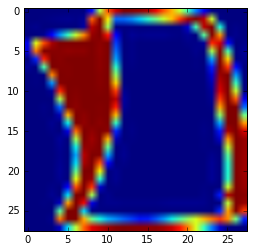

In [4]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
letter = ['A','B','C','D','E','F','G','H','I', 'J']

rnd = np.random.randint(0, len(sanitized_train_ds))
print(letter[sanitized_train_lbl[rnd]], rnd)
plt.imshow(sanitized_train_ds[rnd,:,:])

##### Find Near Duplicates

---
Problem 6
---------

Let's get an idea of what an off-the-shelf classifier can give you on this data. It's always good to check that there is something to learn, and that it's a problem that is not so trivial that a canned solution solves it.

Train a simple model on this data using 50, 100, 1000 and 5000 training samples. Hint: you can use the LogisticRegression model from sklearn.linear_model.

Optional question: train an off-the-shelf model on all the data!

---

In [42]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

def LR_train(n_samples, C, train_ds, train_lbl, test_ds, test_lbl):

    Xtrain = np.array(train_ds[0:n_samples,:,:])
    Xtrain = np.reshape(Xtrain, (n_samples,784))
    ytrain = np.reshape(train_lbl[0:n_samples], (n_samples,))
    logreg = LogisticRegression(C=C,solver='sag', multi_class='ovr')
    #gauss_wgts = np.random.normal(loc=0, scale=0.2, size=n_samples)
    logreg.fit(Xtrain, ytrain)
    
    testX = np.reshape(test_ds, (len(test_ds), 784))
    ypred = logreg.predict(testX)
    
    yresp = np.reshape(test_lbl, (len(test_lbl,)))
    
    return metrics.accuracy_score(yresp, ypred)   

In [43]:
print LR_train(n_samples, .0001, sanitized_train_ds, sanitized_train_lbl, sanitized_test_ds, sanitized_test_lbl)

0.866582103321


(array([  1.10000000e+01,   7.50000000e+01,   3.03000000e+02,
          1.12000000e+03,   3.10400000e+03,   7.16500000e+03,
          1.41380000e+04,   2.23830000e+04,   2.97800000e+04,
          3.34720000e+04,   3.07860000e+04,   2.38750000e+04,
          1.54310000e+04,   8.20800000e+03,   3.63400000e+03,
          1.27400000e+03,   3.92000000e+02,   1.19000000e+02,
          2.10000000e+01,   5.00000000e+00]),
 array([-0.8286955 , -0.74225194, -0.65580838, -0.56936483, -0.48292127,
        -0.39647772, -0.31003416, -0.22359061, -0.13714705, -0.05070349,
         0.03574006,  0.12218362,  0.20862717,  0.29507073,  0.38151428,
         0.46795784,  0.5544014 ,  0.64084495,  0.72728851,  0.81373206,
         0.90017562]),
 <a list of 20 Patch objects>)

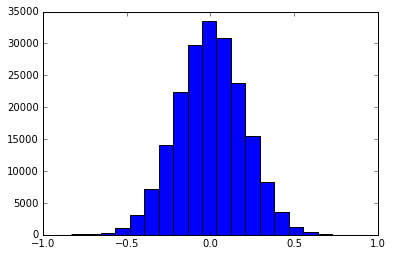

In [35]:
plt.hist(np.random.normal(loc=0, scale=0.2, size=n_samples)
, bins=20)

#### Numerical Stability

In [ ]:
a = 1000000000.0
for i in range(0, 1000000):
    a = a + .000001

print(a)
print(a - 1000000000.0)

In [ ]:
a = 1.0
for i in range(0, 1000000):
    a = a + .000001

print(a)
print(a - 1000000000.0)